In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as plt
from pathlib2 import Path
from PIL import Image
import torch
import math
import torch.nn as nn
from torchvision.transforms import transforms

In [3]:
DATA_PATH = Path(os.getcwd()+"/data")
PATH = DATA_PATH/"kaggle"
TRAIN_PATH = PATH/"Train/"
TEST_PATH = PATH/"Test/"

PATH.mkdir(parents=True, exist_ok=True)
TRAIN_PATH.mkdir(parents=True, exist_ok=True)
TEST_PATH.mkdir(parents=True, exist_ok=True)


In [4]:
dev = torch.device(
     "cuda") if torch.cuda.is_available() else torch.device("cpu")
bs = 128

cpu = torch.device("cpu")

In [5]:
train_x = np.genfromtxt(DATA_PATH/'sketches_train.csv', delimiter=',', dtype=np.uint8)
train_x = train_x/256

test_x = np.genfromtxt(DATA_PATH/'sketches_test.csv', delimiter=',', dtype=np.uint8)
test_x = test_x/256

In [6]:
train_y = np.genfromtxt(DATA_PATH/'labels_np.csv', delimiter=',', dtype=np.uint8) - 1

In [7]:
train_y[511]

0

i = 0
for row in train_x:
    arr = row
    i += 1
    sqr = arr.reshape(28,28)
    img = Image.fromarray(sqr)
    img.save(str(TRAIN_PATH)+"/"+str(i)+".png", "PNG")


i = 0
for row in test_x:
    arr = row
    i += 1
    sqr = arr.reshape(28,28)
    img = Image.fromarray(sqr)
    img.save(str(TEST_PATH)+"/"+str(i)+".png", "PNG")

In [8]:
train_x, train_y, test_x = map(
    torch.tensor, (train_x, train_y, test_x)
)
print(train_x.shape, train_y.shape, test_x.shape)

torch.Size([6000, 784]) torch.Size([6000]) torch.Size([1200, 784])


In [9]:
train_x = train_x.float().to(dev).view(-1, 1, 28, 28)
test_x = test_x.float().to(cpu).view(-1, 1, 28, 28)
train_y = train_y.long().to(dev)

In [10]:
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [11]:
from torch.utils.data import TensorDataset

In [12]:
sketch_ds = TensorDataset(train_x, train_y)

In [13]:
from torch.utils.data import random_split

In [14]:
train_ds, test_ds = random_split(sketch_ds, [4000, 2000])

In [15]:
train_ds[50][0].shape

torch.Size([1, 28, 28])

In [16]:
from torch.utils.data import DataLoader

In [17]:
train_dl = DataLoader(train_ds, shuffle=True, batch_size=bs)
test_dl = DataLoader(test_ds, batch_size=bs * 2)

In [18]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10)/ math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()


def get_model():
    model = Mnist_Logistic().float().to(dev)
    return model, optim.SGD(model.parameters(), lr=lr)

loss_func = F.cross_entropy

In [19]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    acc2 = accuracy(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb), acc2

In [37]:
def save_models(epoch):
    torch.save(model.state_dict(), "kagglemodel_{}.model".format(epoch))
    print("Checkpoint saved")
    

In [41]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            acc = accuracy(model(xb), yb)
        model.eval()
        with torch.no_grad():
            losses, nums, acc2 = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        if 0.35 > val_loss:
            torch.save(model,"kagglemodel_{}.model".format(epoch))
            print("Checkpoint saved")
        
        print(epoch, val_loss, acc, acc2)
        print('\n')


def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )        

train_dl, valid_dl = get_data(train_ds, test_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

tensor(0, device='cuda:0')


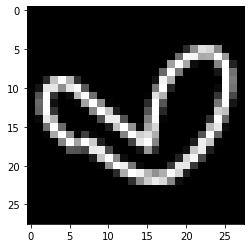

In [22]:
from matplotlib import pyplot
plt.pyplot.imshow(train_x.cpu()[0].reshape((28, 28)), cmap="gray")
print(train_y[0])

bs = 64
lr = 0.1
epochs = 10
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

In [23]:
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unit, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=3, out_channels=out_channels, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

In [24]:
class Unit1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Unit1, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=1, out_channels=out_channels, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

In [25]:
class SimpleNet(nn.Module):
    def __init__(self,num_classes=6):
        super(SimpleNet,self).__init__()
        
        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=1,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=64)
        self.unit3 = Unit(in_channels=64, out_channels=128)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=128, out_channels=128)
        self.unit5 = Unit(in_channels=128, out_channels=128)
        self.unit6 = Unit(in_channels=128, out_channels=128)
        self.unit7 = Unit(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=128, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit1(in_channels=128, out_channels=128)
        self.unit13 = Unit1(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=3)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)

        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output

In [26]:
# class SimpleNet(nn.Module):
#     def __init__(self, num_classes=6):
#         super(SimpleNet, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1)
#         self.relu1 = nn.ReLU()

#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
#         self.relu2 = nn.ReLU()

#         self.pool = nn.MaxPool2d(kernel_size=2)

#         self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
#         self.relu3 = nn.ReLU()

#         self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
#         self.relu4 = nn.ReLU()

#         self.fc = nn.Linear(in_features=14 * 14 * 24, out_features=num_classes)

#     def forward(self, input):
#         output = self.conv1(input)
#         output = self.relu1(output)

#         output = self.conv2(output)
#         output = self.relu2(output)

#         output = self.pool(output)

#         output = self.conv3(output)
#         output = self.relu3(output)

#         output = self.conv4(output)
#         output = self.relu4(output)

#         output = output.view(-1, 14 * 14 * 24)

#         output = self.fc(output)

#         return output
    
model = SimpleNet(num_classes=6)

opt   = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

model.to(dev)

SimpleNet(
  (unit1): Unit(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit2): Unit(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit3): Unit(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit4): Unit(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit5): Unit(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), s

In [43]:
bs = 32
lr = 0.0005
epochs = 20
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
fit(epochs, model, loss_func, opt, train_dl, test_dl)

0 0.3794380965232849 tensor(1., device='cuda:0') (tensor(0.9297, device='cuda:0'), tensor(0.8828, device='cuda:0'), tensor(0.9336, device='cuda:0'), tensor(0.8828, device='cuda:0'), tensor(0.9258, device='cuda:0'), tensor(0.9023, device='cuda:0'), tensor(0.9219, device='cuda:0'), tensor(0.9327, device='cuda:0'))


1 0.4382816245555878 tensor(1., device='cuda:0') (tensor(0.9297, device='cuda:0'), tensor(0.8789, device='cuda:0'), tensor(0.9180, device='cuda:0'), tensor(0.8984, device='cuda:0'), tensor(0.9102, device='cuda:0'), tensor(0.9141, device='cuda:0'), tensor(0.9375, device='cuda:0'), tensor(0.9327, device='cuda:0'))


2 0.4264542098045349 tensor(1., device='cuda:0') (tensor(0.9023, device='cuda:0'), tensor(0.9023, device='cuda:0'), tensor(0.9336, device='cuda:0'), tensor(0.8867, device='cuda:0'), tensor(0.9141, device='cuda:0'), tensor(0.9062, device='cuda:0'), tensor(0.9297, device='cuda:0'), tensor(0.9327, device='cuda:0'))


3 0.3932993655204773 tensor(1., device='cuda:0') (te

In [46]:
model_best = torch.load(str(PATH/'035.model')).to(cpu)
model_best.eval()
test_y = []
for row in test_x:
    res = model_best(row.unsqueeze(0))
    test_y.append(res)



In [47]:
len(test_y)

1200

In [48]:
preds = []
for row in test_y:
    pred = torch.argmax(row[0], dim=-1)
    preds.append(pred.item()+1)

In [49]:
key = { 1: 'boomerang', 2:'kangaroo', 3:'crab', 4:'cactus', 5:'flip flops', 6:'banana' }

preds2 = []
for item in preds:
    preds2.append(key[item])

cactus


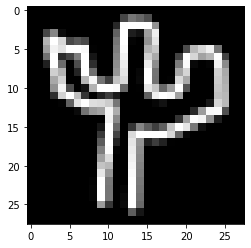

In [50]:
x = 653
plt.pyplot.imshow(test_x[x].reshape((28, 28)), cmap="gray")
print(preds2[x])

In [50]:
import csv

with open("results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(preds2)